In [1]:
!pip install hazm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
from hazm import word_tokenize
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df=pd.read_csv("/content/drive/MyDrive/Spell_correction/data.csv")

In [5]:
df=df[(df['main_category']=="Main signs") | (df['main_category']=="Form")]

In [6]:
Arab=['Bahrain','Algeria','Iraq','Kuwait','Lebanon','Palestine','Saudi Arabia','Sudan','Syria','Yemen']
Latin=['Argentina','Austria','Australia','Belgium','France','Colombia','Germany','Ghana','Hungary','Italy','Ivory Coast','Netherlands','Portugal','Romania','Senegal','Spain','Switzerland','United Kingdom','United States of America','']
Turk=['Azerbaijan','Kazakhstan','Kyrgyzstan','Turkey']
Pars=['Afghanistan','Iran','Pakistan','Tajikistan']
India=['Bangladesh','India']
Russia=['Belarus','Croatia','Poland','Russia','Serbia','Czech Republic','Slovakia','Ukraine','Bulgaria','North Macedonia']
china=['China']



def batch_nationality(nationality):
  if nationality in Arab:
    return "Arab"
  elif nationality in Latin:
    return "Latin"
  elif nationality in Turk:
    return "Turk"
  elif nationality in Pars:
    return "Pars"
  elif nationality in India:
    return "India"
  elif nationality in Russia:
    return "Russia"
  elif nationality in china:
    return "China"
  else:
    return "Other"

In [7]:
df['wrong_sentence'] = df.apply(lambda row: f"[{batch_nationality(row['Nationality'])}] {row['wrong_sentence']}", axis=1)

In [8]:
df=df[["wrong_sentence","correct_sentence"]]
df=df.dropna()

In [9]:
df.head()

,wrong_sentence,correct_sentence
1,[Pars] افغانستان\n \n موضوع : اسراف\n \n اسراف...,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...
3,[Pars] افغانستان\n \n موضوع : اسراف\n \n اسراف...,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...
4,[Pars] افغانستان\n \n موضوع : اسراف\n \n اسراف...,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...
7,[Pars] افغانستان\n \n موضوع : اسراف\n \n اسراف...,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...
8,[Pars] افغانستان\n \n موضوع : اسراف\n \n اسراف...,افغانستان\n \n موضوع : اسراف\n \n اسراف را خدا...


In [10]:
df,Test=train_test_split(df,test_size=0.2,random_state=24)

In [11]:
len(df)

4739

In [12]:
#create vocabulay
symbols_to_remove = ['@', '#', '$', '%', '^', '&', '*', '(', ')','{','}','"','*\r','+',',','ø','>>','CV','EXPO','None','alfare','fat','«','0-9','\\u200','\\u200c','\\u200f','\\u200e']
# Create a regex pattern that matches any of the symbols in the list
pattern = re.compile(f"[{re.escape(''.join(symbols_to_remove))}]")

In [13]:
# create a dictionary to convert the vocabulary to integers
vocab_to_int = {}
count = 0
#tokenize and put <start> , < end >
# Add special tokens to vocab_to_int
codes = ['<PAD>','<eos>','<sos>']
for code in codes:
    vocab_to_int[code] = count
    count += 1

for index in df.index:
    for word in word_tokenize(df.at[index,"wrong_sentence"]):
        cleaned_string = pattern.sub("", word)
        # cleaned_string = new_word.replace("\u200c", "").replace("\u200f", "")
        if cleaned_string not in vocab_to_int:
            vocab_to_int[cleaned_string] = count
            count += 1
    for word in word_tokenize(df.at[index,"correct_sentence"]):
        cleaned_string = pattern.sub("", word)
        # cleaned_string = new_word.replace("\u200c", "").replace("\u200f", "")
        if cleaned_string not in vocab_to_int:
            vocab_to_int[cleaned_string] = count
            count += 1

In [14]:
vocab_size = len(vocab_to_int)
print("The vocabulary contains {} words.".format(vocab_size))

The vocabulary contains 8566 words.


In [15]:
# Create another dictionary to convert integers to their respective characters
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

In [16]:
#change input to tokens_id
def tokenizer(sentence):
    tmp=[]
    tmp.append(vocab_to_int["<sos>"])
    for word in word_tokenize(sentence):
        cleaned_string = pattern.sub("", word)
        if cleaned_string not in vocab_to_int:
            tmp.append(vocab_to_int["<PAD>"])
        else:
          tmp.append(vocab_to_int[cleaned_string])
    tmp.append(vocab_to_int["<eos>"])
    # padded_sequences = tf.keras.preprocessing.sequence.pad_sequences([tmp],maxlen=512 ,padding='post', value=vocab_to_int["<PAD>"])
    return tmp



In [17]:
def detokenizer(tokens):
    tmp=""
    for token in tokens:
        tmp+=int_to_vocab[token]+" "
    return tmp

In [18]:
lengths = []

for ind in df.index:
  wr_tokens = tokenizer(df.at[ind,"wrong_sentence"])
  lengths.append(len(wr_tokens))
  cor_tokens = tokenizer(df.at[ind,"correct_sentence"])
  lengths.append(len(cor_tokens))

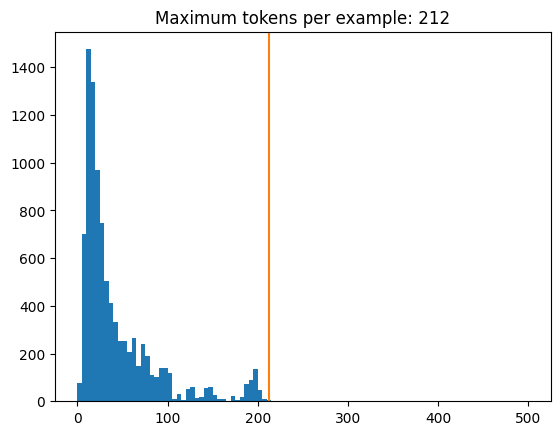

In [19]:

plt.hist(lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

In [20]:
wrong_sentence=[]
correct_sentence_inputs=[]
correct_sentence_labels=[]
# MAX_TOKENS=256
for ind in df.index:
  wrong=tokenizer(df.at[ind,"wrong_sentence"])
  # wrong=wrong[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
  wrong_sentence.append(tf.keras.preprocessing.sequence.pad_sequences([wrong],maxlen=256 ,padding='post', value=vocab_to_int["<PAD>"],truncating='post')
)
  correct_inputs=tokenizer(df.at[ind,"correct_sentence"])
  # correct_sentence = correct_inputs[:, :(MAX_TOKENS+1)]
  correct_sentence_inputs_one = correct_inputs[:-1]     #drop <eos>
  correct_sentence_labels_one=correct_inputs[1:]        #drop <sos>
  correct_sentence_inputs .append(tf.keras.preprocessing.sequence.pad_sequences([correct_sentence_inputs_one],maxlen=256 ,padding='post', value=vocab_to_int["<PAD>"],truncating='post') )
  correct_sentence_labels .append(tf.keras.preprocessing.sequence.pad_sequences([correct_sentence_labels_one],maxlen=256 ,padding='post', value=vocab_to_int["<PAD>"],truncating='post') )


In [21]:
df=pd.DataFrame({
    "wrong_sentence":wrong_sentence,
    "correct_sentence_inputs":correct_sentence_inputs,
    "correct_sentence_labels":correct_sentence_labels
})

In [22]:
train,test=train_test_split(df,test_size=0.2,random_state=24)

In [23]:
correct_label=tf.convert_to_tensor(train['correct_sentence_labels'].tolist(), dtype=tf.int64)
wrong=tf.convert_to_tensor(train['wrong_sentence'].tolist(), dtype=tf.int64)
correct_inputs=tf.convert_to_tensor(train['correct_sentence_inputs'].tolist(), dtype=tf.int64)



correct_label_test=tf.convert_to_tensor(test['correct_sentence_labels'].tolist(), dtype=tf.int64)
wrong_test=tf.convert_to_tensor(test['wrong_sentence'].tolist(), dtype=tf.int64)
correct_inputs_test=tf.convert_to_tensor(test['correct_sentence_inputs'].tolist(), dtype=tf.int64)



In [24]:
correct_label=tf.squeeze(correct_label, axis=1)
wrong=tf.squeeze(wrong, axis=1)
correct_inputs=tf.squeeze(correct_inputs, axis=1)

correct_label_test=tf.squeeze(correct_label_test, axis=1)
wrong_test=tf.squeeze(wrong_test, axis=1)
correct_inputs_test=tf.squeeze(correct_inputs_test, axis=1)


In [25]:

tensor_dict = (
     wrong,
     correct_inputs)
tensor_dict_test = (
     wrong_test,
     correct_inputs_test
)

In [26]:
dataset_train = tf.data.Dataset.from_tensor_slices((tensor_dict,correct_label))
dataset_test = tf.data.Dataset.from_tensor_slices((tensor_dict_test,correct_label_test))

In [27]:

MAX_TOKENS=128
def prepare_batch(wrong_sentence,correct_sentence):
    wrong_sentence = tokenizer(wrong_sentence)      # Output is ragged.
    wrong_sentence = wrong_sentence[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    print(wrong_sentence)
    wrong_sentence = wrong_sentence.to_tensor()  # Convert to 0-padded dense Tensor

    correct_sentence = tokenizer(correct_sentence)
    correct_sentence = correct_sentence[:, :(MAX_TOKENS+1)]
    correct_sentence_inputs = correct_sentence[:, :-1].to_tensor()  # Drop the [END] tokens
    correct_sentence_labels = correct_sentence[:, 1:].to_tensor()   # Drop the [START] tokens

    return (wrong_sentence, correct_sentence_inputs), correct_sentence_labels

In [28]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [29]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE))
      # .map(prepare_batch, tf.data.AUTOTUNE)
      # .prefetch(buffer_size=tf.data.AUTOTUNE))

In [30]:
# Create training and validation set batches.
train_batches = make_batches(dataset_train)
val_batches = make_batches(dataset_test)

In [31]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)


In [32]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [33]:
for (wrong_sentence,correct_sentence), correct_sentence_labels in train_batches.take(1):
  break
print(wrong_sentence.shape)
print(correct_sentence.shape)
print(correct_sentence_labels.shape)
print(tf.shape(wrong_sentence))

(64, 256)
(64, 256)
(64, 256)
tf.Tensor([ 64 256], shape=(2,), dtype=int32)


In [34]:
embed_wrong = PositionalEmbedding(vocab_size=len(vocab_to_int), d_model=512)
embed_correct = PositionalEmbedding(vocab_size=len(vocab_to_int), d_model=512)

wrong_emb = embed_wrong(wrong_sentence)
correct_emb = embed_correct(correct_sentence)
print(wrong_emb.shape)

(64, 256, 512)


In [35]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()


In [36]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [37]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [38]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [39]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [40]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [41]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.


In [42]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [43]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [44]:
@tf.keras.utils.register_keras_serializable()
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1,**kwargs):
    super(Transformer, self).__init__(**kwargs)
    self.num_layers = num_layers
    self.d_model = d_model
    self.num_heads = num_heads
    self.dff = dff
    self.input_vocab_size = input_vocab_size
    self.target_vocab_size = target_vocab_size
    self.dropout_rate = dropout_rate
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits
  def get_config(self):
      config = super(Transformer, self).get_config()
      # Add additional config parameters if needed
      config.update({
          'num_layers': self.num_layers,
          'd_model': self.d_model,
          'num_heads': self.num_heads,
          'dff': self.dff,
          'input_vocab_size': self.input_vocab_size,
          'target_vocab_size': self.target_vocab_size,
          'dropout_rate': self.dropout_rate,
      })
      return config

In [45]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [46]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(vocab_to_int),
    target_vocab_size=len(vocab_to_int),
    dropout_rate=dropout_rate)

In [47]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(vocab_to_int),
    target_vocab_size=len(vocab_to_int),
    dropout_rate=dropout_rate)

In [48]:
@tf.keras.utils.register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  def get_config(self):
        return {
            'd_model': self.d_model.numpy(),  # Convert tensor to Python float
            'warmup_steps': self.warmup_steps,
        }

In [49]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

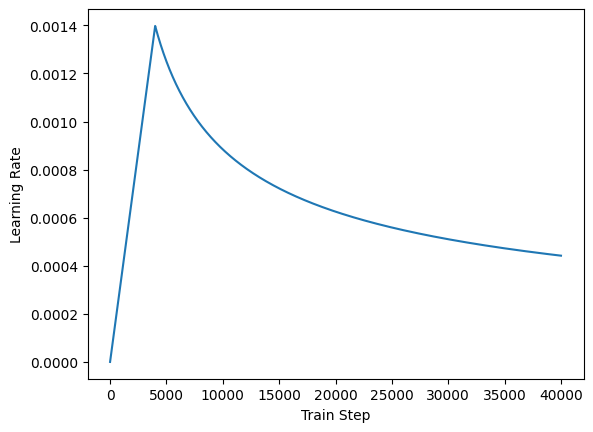

In [50]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [51]:
@tf.keras.utils.register_keras_serializable()
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


In [52]:
@tf.keras.utils.register_keras_serializable()
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [53]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [54]:
history=transformer.fit(train_batches,
                epochs=30,
                validation_data=val_batches)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ke

60/60 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - loss: 9.0355 - masked_accuracy: 0.0020 - val_loss: 8.8554 - val_masked_accuracy: 0.0542
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 639ms/step - loss: 8.7958 - masked_accuracy: 0.0544 - val_loss: 8.5829 - val_masked_accuracy: 0.0601
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 608ms/step - loss: 8.4826 - masked_accuracy: 0.0629 - val_loss: 8.1634 - val_masked_accuracy: 0.0754
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 613ms/step - loss: 8.0316 - masked_accuracy: 0.0819 - val_loss: 7.6656 - val_masked_accuracy: 0.0920
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 648ms/step - loss: 7.5173 - masked_accuracy: 0.0964 - val_loss: 7.1768 - val_masked_accuracy: 0.1073
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 613ms/step - loss: 7.0382 - masked_accuracy: 0.1132 - val_loss: 6.7559 - val_masked_accuracy: 0.1317
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 646ms/step - loss: 6.6166 - masked_accuracy: 0.1551 - val_loss: 6.3871 - val_masked_accuracy: 0.1787
Epoch 8/30
6

In [55]:
history_dict = history.history

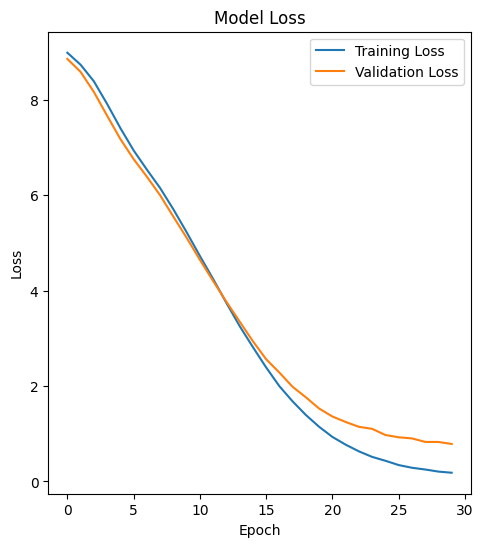

<Figure size 640x480 with 0 Axes>

In [56]:
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# If you have accuracy or another metric, you can plot it similarly
if 'accuracy' in history_dict and 'val_accuracy' in history_dict:
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

# Show the plots
plt.show()
plt.savefig('/content/drive/MyDrive/Spell_correction/model/with_batch_nationality.png', dpi=300, bbox_inches='tight', transparent=True)

In [57]:
transformer.save("/content/drive/MyDrive/Spell_correction/model/with_batch_nationality.keras")

In [58]:
Test.to_csv('/content/drive/MyDrive/Spell_correction/model/with_batch_nationality_Test.csv', index=False)

In [59]:
with open('/content/drive/MyDrive/Spell_correction/model/with_batch_nationality.pkl', 'wb') as file:
    pickle.dump(vocab_to_int, file)